In [2]:
import numpy as np
import re
import requests
from bs4  import BeautifulSoup as soup
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pychord import Chord, ChordProgression
import itertools
import pickle
import os
import glob

%matplotlib inline

In [3]:
import pandas as pd
import altair as alt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from pychord import Chord,ChordProgression
from synthesizer import Player, Synthesizer, Waveform
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn import datasets

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem

from timeit import default_timer as timer
import time
import pprint



In [4]:
import warnings
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
# from graphrole import RecursiveFeatureExtractor, RoleExtractor

/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def doit(i):
    allstuffs = []
    if 0 in i:
        
        allstuffs.append(lambda x:'a'+str(x))
    if 1 in i:
        
        allstuffs.append(lambda x: 'a1')
    def run(G):
        piku = []
        for i in allstuffs:
            piku.append(i(G))
        return piku
    return run
kkk = doit([0,1])
kkk(0)


['a0', 'a1']

In [6]:
allfeat = [
    'node',
    'edge',
    'clust',
    'clust-g',
    'apl',
    'sdev-apl', 
    'sdev-apl-g',
    'sdev-pagerank-g', 
    'sdev-pagerank', 
    'pagerank', 
    'pagerank-max', 
    'sdev-clust-g', 
    'sdev-clust', 
    'apl-g', 
    'pagerank-max-g',
    
]
pp = pprint.PrettyPrinter(indent=4)

In [7]:
def drawG(G, drawsize=10):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights )
    return G

class SongChords:
    def __init__(self, c, G):
        self.c = c
        self.G = G
    def get(self):
        return (self.c, self.G)


def to_weighted(G):
    M = G.copy()
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G


def to_g(G):
    M = G.copy()
    G = nx.Graph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

def getsong(num):
    full = f'/Users/xieewenz/python/Networkx/ChordNetwork/*/*{str(num)}.pickle'
    s = glob.glob(full)
    if len(s)>1: 
        print('more than one match??!!')
        print(s[0])
    else:
        print(s[0])
    s = pickle.load(open(s[0],'rb'))
    return s

def weighted_apl_clust(G, features = ['node','edge']):
#     return (nx.average_clustering(G),nx.average_shortest_path_length(G))
#     return (G.number_of_nodes(), G.number_of_edges())
#     return (nx.average_shortest_path_length(G), G.number_of_edges(), G.number_of_nodes())
    ret = {}
    if 'apl' in features:
        ret['apl'] = nx.average_shortest_path_length(G)
    if 'sdev-apl' in features:
        n = []
        for i in [list(i[1].values())[1:] for i in nx.shortest_path_length(G)]:
            n+=i
        ret['sdev-apl'] = np.std(n)
    if 'sdev-apl-g' in features:
        n = []
        for i in [list(i[1].values())[1:] for i in nx.shortest_path_length(to_g(G))]:
            n+=i
        ret['sdev-apl-g'] = np.std(n)
    if 'apl-g' in features:
        ret['apl-g']  =  nx.average_shortest_path_length(to_g(G))
    if 'node' in features:
        ret['node'] = G.number_of_nodes()
    if 'edge' in features:
        ret['edge'] = G.number_of_edges()
    if 'edge-g' in features:
        ret['edge-g'] = to_weighted(G).number_of_edges()
    if 'clust' in features:
        ret['clust']=nx.average_clustering(to_weighted(G))
    if 'clust-g' in features:
        ret['clust-g']=nx.average_clustering(to_g(G))
    if 'sdev-clust' in features:
        ret['sdev-clust'] = np.std(list(nx.clustering(to_weighted(G)).values()))
    if 'sdev-clust-g' in features:
        ret['sdev-clust-g'] = np.std(list(nx.clustering(to_g(G)).values()))
    if 'pagerank-max' in features:
        ret['pagerank-max']=np.amax(list(nx.pagerank(to_weighted(G)).values()))
    if 'pagerank-max-g' in features:
        G_temp = to_weighted(G)
        G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
        ret['pagerank-max-g']=np.amax(list(nx.pagerank(G_temp).values()))
    if 'pagerank-max-node' in features:
        ret['pagerank-max-node']=list(nx.pagerank(to_weighted(G)).keys())[np.argmax(list(nx.pagerank(to_weighted(G)).values()))]
    if 'pagerank-max-nodes' in features:
        pgd = nx.pagerank(to_weighted(G))
        ret['pagerank-max-nodes']={k: v for k, v in sorted(pgd.items(), key=lambda item: item[1])}
    if 'pagerank' in features:
        ret['pagerank']= np.average(list(nx.pagerank(to_weighted(G)).values()))
    if 'sdev-pagerank' in features:
        ret['sdev-pagerank'] = np.std(list(nx.pagerank(to_weighted(G)).values()))
    if 'sdev-pagerank-g' in features:
        ret['sdev-pagerank-g'] = np.std(list(nx.pagerank(to_g(G)).values()))
    if 'smallworld'  in features:
        ret['smallworld'] = nx.smallworld.sigma(to_g(G))
    return [ret[i] for i in features]

In [8]:
1+1

2

In [12]:
names = [
#     'general',
#     'general-big',
#     'pop',
#     'jazz',
#     'blues',
#     'metal',
#     'rock',
#     'the_beatles_1916',
#     'ramones_555', 
#     'frank_sinatra_11333', 
#     'metallica_954', 
    
#     'linkin_park_1025',
#     'passenger_21762',
#     'bruno_mars_28280',
#     'adele_20519',
    
#     'elvis_presley_11125',
#     'etta_james_20433',
#     'gary_moore_10959',


#     'billie_eilish_66748',
#     'taylor_swift_16027',
#     'lady_gaga_21818',
    
    '1960',
    '1970',
    '1980',
    '1990',
    '2000',
    '2010',
]


# features = ['node','apl', 'clust','sdev-apl','sdev-clust']
features = [
    'node',
    'edge',
    'edge-g',
    'clust',
    'clust-g',
    'apl',
    'sdev-apl', 
    'sdev-apl-g',
    'sdev-pagerank-g', 
    'sdev-pagerank', 
    'pagerank', 
    'pagerank-max', 
    'sdev-clust-g', 
    'sdev-clust', 
    'apl-g', 
#     'smallworld',
    'pagerank-max-g',

]

songcodes = []

songs = []
filelists = [f'./{n}-2d/*.edgelist' for n in names]
for fl in filelists:
    current = re.search(r'/([\w-]+)',fl)
    al = current.group(1)
    artist = glob.glob(fl)
    data = []
    for i in tqdm(artist):
        # create using ???
        G = nx.read_edgelist(i,comments='`',create_using=nx.MultiDiGraph)
        
        current = re.search(r'/([\w-]+).edgelist',i)
        name = current.group(1)
        code = re.search(r'-(\d+)$',name)
        songcodes.append(code.group(1))
        # node_edge ???
#         try:
        songs.append([name, al]+list(weighted_apl_clust(G, features = features)))
#         except:
#             continue

d = np.array(songs).T
data = {
    'name':d[0],
    'artist':d[1],
}
for n, f in enumerate(features):
    data[f]=d[n+2].astype(float)
df = pd.DataFrame(data)


df0 = df.copy()
y = df0.pop('artist')
X = df0.drop('name', axis=1)
# X = df

df.head(3)

 24%|██▎       | 42/177 [00:02<00:08, 16.35it/s]/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 211/211 [00:08<00:00, 24.25it/s]


,name,artist,node,edge,edge-g,clust,clust-g,apl,sdev-apl,sdev-apl-g,sdev-pagerank-g,sdev-pagerank,pagerank,pagerank-max,sdev-clust-g,sdev-clust,apl-g,pagerank-max-g
0,i-want-you-back-chords-844690,1960-2d,6.0,182.0,15.0,0.550061,0.822222,1.633333,0.657436,0.442217,0.054542,0.067518,0.166667,0.287886,0.151127,0.130803,1.266667,0.221044
1,girl-from-the-north-country-chords-1087317,1960-2d,6.0,86.0,9.0,0.291667,0.583333,1.633333,0.773563,0.618241,0.136364,0.138392,0.166667,0.403917,0.356812,0.178406,1.533333,0.303366
2,500-miles-chords-1045017,1960-2d,12.0,60.0,20.0,0.236706,0.372222,2.916667,1.621141,0.840465,0.066208,0.065295,0.083333,0.208088,0.385101,0.284235,2.075758,0.221076


0it [00:00, ?it/s]
0it [00:00, ?it/s]


beginnn
Classification score 0.39753086419753086 (pvalue : 0.009900990099009901)
0.2
0.39753086419753086
0.2527901234567901


/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


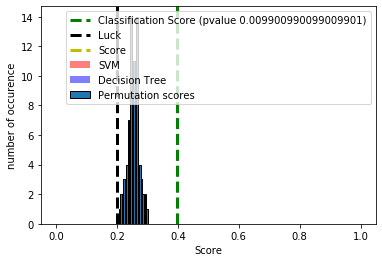

In [11]:
# permuattion scores
n_permutations = 100


# svm
test_times = 0


ala = []
for i in tqdm(range(test_times)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     clf = svm.SVC(kernel='rbf',gamma='auto')
    clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=9000, dual=False))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala.append(accuracy_score(y_test, y_pred))

ala2 = []
for i in tqdm(range(test_times)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = tree.DecisionTreeClassifier()

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala2.append(accuracy_score(y_test, y_pred))

plt.xlabel('accuracy')
plt.ylabel('number of occurence')
plt.hist(ala, color='red', alpha=0.5, label='SVM')
plt.hist(ala2, color='blue', alpha=0.5, label='Decision Tree')
plt.legend()



n_classes = np.unique(y).size

# Some noisy data not correlated
# random = np.random.RandomState(seed=0)
# E = random.normal(size=(len(X), 2200))

# # Add noisy data to the informative features for make the task harder
# X = np.c_[X, E]

clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=19000, dual=False))
# clf = tree.DecisionTreeClassifier()
cv = StratifiedKFold(3)

print('beginnn')

score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=-1,)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# plt.figure(figsize=(10,10))
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.plot(2 * [np.average(ala)], ylim, '--y', linewidth=3, label='Score')

print(1. / n_classes)
print(score)
print(np.average(permutation_scores))
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [13]:
musicians = []#pd.DataFrame([{'healp':0},{'healp':1}])
m_feats = []
for n in names:
    mus = {}
    mus['name'] = n
    n = n+'-2d'
    musician_data = df.loc[df['artist'] == n]
    for f in features:
        f_data = musician_data[f]
        mus[f+'-avg'] = np.average(f_data)
        mus[f+'-sdev'] = np.std(f_data)
    musicians.append(mus)
for f in features:
    m_feats+=[f+'-avg',f+'-sdev']
df_musician = pd.DataFrame(musicians)


In [193]:
df_musician

,name,node-avg,node-sdev,edge-avg,edge-sdev,clust-avg,clust-sdev,apl-avg,apl-sdev,pagerank-max-avg,pagerank-max-sdev
0,the_beatles_1916,7.913669,3.154264,64.553957,27.350686,0.394553,0.220315,2.027133,0.461251,0.315936,0.091975
1,frank_sinatra_11333,17.130137,8.059933,77.000000,34.859994,0.175844,0.120356,3.207123,0.863267,0.173698,0.060798
2,passenger_21762,6.020833,2.530971,97.796875,33.957624,0.548224,0.200562,1.674971,0.374603,0.308331,0.063764
3,elvis_presley_11125,9.015873,4.322301,55.682540,20.202016,0.327962,0.221355,2.266949,0.537869,0.283000,0.082112


In [34]:
# df_musician

In [333]:
df0 = df.copy()
y = df0.pop('artist')
X = df0.drop('name', axis=1)
# X = df

In [364]:
print(len(X), set(y))

577 {'1970-2d', '1960-2d', '1980-2d'}


In [401]:
# repeat graph

input_dropdown = alt.binding_select(options=[n+'-2d' for n in names])
selection = alt.selection_single(fields=['artist'], bind=input_dropdown, name='Artist')
color = alt.condition(selection,
                    alt.Color('artist:N', legend=None),
                    alt.value('lightgray'),
                   )




# brush = alt.selection_interval()  # selection of type "interval"
color = alt.condition(selection, 'artist:N', alt.value('lightgray'))
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.01))
# palette = alt.Scale(domain=['ramones_555-2d', 'the_beatles_1916-2d', 'frank_sinatra_11333-2d','metallica_954-2d','linkin_park_1025-2d'],
#                   range=['red', 'blue', 'green', 'orange', 'yellow'])

alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X(alt.repeat("column"), type='quantitative'),
    y=alt.Y(alt.repeat("row"), type='quantitative'),
    color=color, # alt.Color('artist',scale = palette)
    opacity = opacity,
    tooltip=['name', 'artist']+features,
).properties(
    width=150,
    height=150
).add_selection(
    selection
).repeat(
    row=features,
    column=features[::-1]
)



alt.RepeatChart(...)

In [290]:
# repeat for musician and genre

alt.Chart(df_musician).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='name',
    tooltip = ['name',]+m_feats
).properties(
    width=100,
    height=100
    
).repeat(
    row=m_feats,
    column=m_feats[::-1]
)

In [22]:
# ugly bar



ct = alt.Chart(df_musician).mark_bar().encode(
    x=alt.X('name', axis=None),
    tooltip = ['name'],
    color='name',
#     column='day_of_week:N'
).properties(width=80)
res = ct.encode(y=m_feats[0])

for i in m_feats[1:]:
    res = res | ct.encode(y=i)
res

alt.HConcatChart(...)

In [203]:

# bar graph

selection = alt.selection_multi(fields=['artist',])

color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))

bars = alt.Chart(df).mark_bar().encode(
    x='artist:O',
    color=color,
    tooltip='artist'
).interactive()

error_bars = alt.Chart(df).mark_errorbar(extent='ci').encode(
    x='artist:O',
)

res = bars.encode(y=f'mean({features[0]}):Q')+error_bars.encode(y=f'{features[0]}:Q')

for i in features[1:]:
    res = res|bars.encode(y=f'mean({i}):Q')+error_bars.encode(y=f'{i}:Q')

alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection) | res

alt.HConcatChart(...)

In [666]:


selection = alt.selection_multi(fields=['artist',])

color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))

opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))

make_selector = alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection)

chart = alt.Chart(df).mark_circle(size=16).encode(color=color,x=features[0],y=features[1], opacity=opacity,tooltip=['name', 'artist']+features,
).transform_filter(selection).interactive()

make_selector | chart



alt.HConcatChart(...)

In [169]:
# input_dropdown = alt.binding_select(options=[n+'-2d' for n in names])
# selection = alt.selection_single(fields=['artist'], bind=input_dropdown, name='Artist')
selection = alt.selection_multi(fields=['artist',])

color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))
make_selector = alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection)
brush = alt.selection_interval()  # selection of type "interval"
color = alt.condition(brush, 'artist:N', alt.value('lightgray'))
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.0))
chart = alt.Chart(df).mark_circle(size=16).encode(x=features[0], color=color, opacity = opacity,tooltip=['name', 'artist']+features,
).add_selection(selection).add_selection(brush)#.transform_filter(selection)
make_selector | chart.encode(y=features[1]) | chart.encode(y=features[2])| chart.encode(y=features[3])#| chart.encode(y=features[4])

alt.HConcatChart(...)

In [170]:
#node edge apl clust

# input_dropdown = alt.binding_select(options=[n+'-2d' for n in names])
selection = alt.selection_interval() 
# color = alt.condition(selection, alt.Color('artist:N', legend=None), alt.value('lightgray'))
# color = alt.condition(selection, 'artist:N', alt.value('lightgray'))
# selection = alt.selection_multi(fields=['artist',])
color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))
make_selector = alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))
chart = alt.Chart(df).mark_circle(size=10).encode(color=color, opacity = opacity,tooltip=['name', 'artist']+features,
).add_selection(selection)
make_selector|chart.encode(x=features[0],y=features[1]) | chart.encode(x=features[5],y=features[4]) 

alt.HConcatChart(...)

In [607]:
x = np.linspace(10,1000,num=5)
dt=[]
for i in tqdm(x):
    k = nx.fast_gnp_random_graph(n=int(i), p=0.3)
    giant = max(nx.connected_component_subgraphs(k), key=len)
    k = nx.subgraph(k, giant)
    dt.append([k.number_of_edges(),k.number_of_nodes(),nx.average_clustering(k),nx.average_shortest_path_length(k)])





100%|██████████| 5/5 [29:29<00:00, 353.86s/it]


In [608]:
alt.Chart(pd.DataFrame(dt, columns=['n','e','c','p'])).mark_circle(size=60).encode(x="e",y='p').interactive()

alt.Chart(...)

In [88]:
snum

'1140752'

In [137]:
def drawG(G, drawsize=10):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights,with_labels=True )#, font_size=20, node_color='#F2C665',node_size=500)
    return G
def drawsubG(G, drawsize=10, sub=111):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.subplot(sub)
    nx.draw_networkx(G, width=weights,with_labels=True )#, font_size=20, node_color='#F2C665',node_size=500)
    return G
def getG(G, drawsize=10):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    return G

more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/back-in-the-ussr-chords-17410.pickle
{   'apl': 1.9285714285714286,
    'apl-g': 1.4761904761904763,
    'clust': 0.6459637188208617,
    'clust-g': 0.7571428571428571,
    'edge': 75,
    'node': 7,
    'pagerank': 0.14285714285714288,
    'pagerank-max': 0.3569354880638588,
    'pagerank-max-g': 0.3569354880638588,
    'pagerank-max-node': 'D',
    'pagerank-max-nodes': {   'A': 0.27365857161930746,
                              'C': 0.1488556449529736,
                              'D': 0.3569354880638588,
                              'E': 0.09425400587998504,
                              'E7': 0.03287364715597654,
                              'Eb': 0.06188097100517613,
                              'Gadd9': 0.031541671322722606},
    'sdev-apl': 0.7985957062499248,
    'sdev-apl-g': 0.49943278484292924,
    'sdev-clust': 0.31448084664933357,
    'sdev-clust-g': 0.28212025225902143,
    'sdev-page

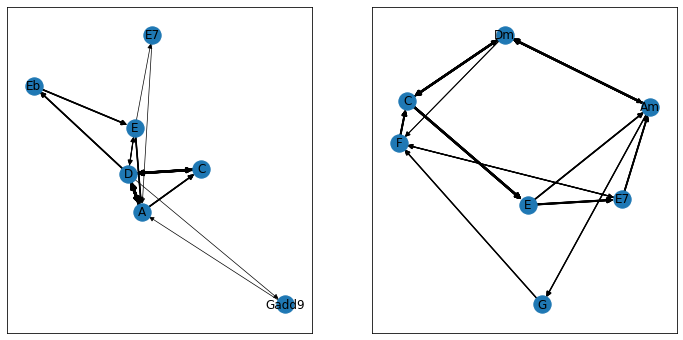

In [198]:
snum = 17410#songcodes[57]
plt.figure(figsize=(12,6))
G_an = drawsubG(getsong(snum).get()[1],drawsize=6,sub=121)
# print(nx.number_of_selfloops(G_an))
feat_res = weighted_apl_clust(G_an, allfeat[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'])
f = {i:j for i,j in zip( allfeat[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'], feat_res)}
pp.pprint(f)
snum2 = 2702754
G_an = drawsubG(getsong(snum2).get()[1],drawsize=6,sub=122)
feat_res = weighted_apl_clust(G_an, allfeat[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'])
f = {i:j for i,j in zip( allfeat[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'], feat_res)}
pp.pprint(f)

# %store G_an
# %store f

In [111]:
Chord('E6').components()

['E', 'G#', 'B', 'C#']

In [24]:
counter=33

In [102]:
import pygraphviz
from IPython.display import display, Markdown
from networkx.drawing.nx_agraph import to_agraph 

In [113]:
counter +=1

# define the graph as per your question
G_an = ggg
G = to_weighted(G_an)

# add graphviz layout options (see https://stackoverflow.com/a/39662097)
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
G.graph['graph'] = {'scale': '2'}

# adding attributes to edges in multigraphs is more complicated but see
# https://stackoverflow.com/a/26694158                    
# G[1][1][0]['color']='red'
for u,v,d in G.edges(data=True):
    d['label'] = int(d.get('weight',''))
    
A = to_agraph(G) 
A.graph_attr.update(overlap='false')
A.layout(prog='neato') 
# ['neato'|'dot'|'twopi'|'circo'|'fdp'|'nop']
A.draw(f'multi{str(counter)}.png')  
display(Markdown(f"![graph](multi{str(counter)}.png)"))

![graph](multi29.png)

In [1]:
# ggg = nx.MultiDiGraph()
# ggg.add_edges_from([['a','b'],['b','c'],['c','d'],['c','a'],['d','b']])
snum = songcodes[48]
ggg =getG(getsong(snum).get()[1],drawsize=6)
# plt.subplot(212)
plt.figure(figsize=(6,6))
o = nx.pagerank(to_weighted(ggg))
oo = sorted(o,key=lambda x:o[x], reverse=True)
# nx.draw(ggg)
# top = min(len(oo),3)
top = min(int(len(oo)/3), 5)
top = 5

color = {i:'#1E79B4' for i in list(ggg.nodes())}
counter = 0
for i in oo:
    if counter == 0:
        color[i] = '#D50104'
    elif counter == 1:
        color[i] = '#F77271'
    elif counter == 2:
        color[i] = '#B75540'
    else:
        #color[i] = '#656E88'
        pass
    counter +=1
color = list(color.values())
nx.draw_networkx(ggg, node_color=color, font_size=20, node_size=500)

NameError: name 'songcodes' is not defined

In [126]:
print(Chord('C').components())
print(Chord('Am').components())
print(Chord('Bm').components())
print(Chord('D').components())


['C', 'E', 'G']
['A', 'C', 'E']
['B', 'D', 'F#']
['D', 'F#', 'A']


In [118]:
from pychord import note_to_chord
note_to_chord(["C", "E", "G",'A'])

[<Chord: C6>, <Chord: Am7/C>]

more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/someone-you-loved-chords-3084521.pickle


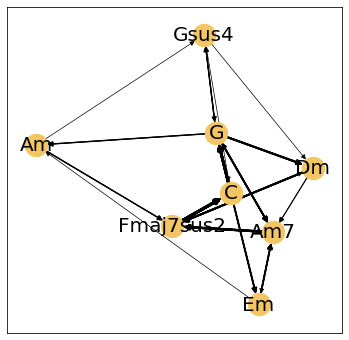

In [161]:
snum = 3084521
drawG(getsong(snum).get()[1],drawsize=6)

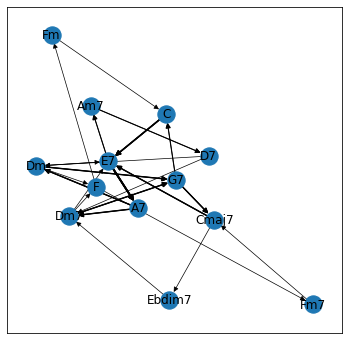

In [196]:
print(*getsong(snum2).get()[0])

more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/lost-chords-2702754.pickle
Am Am Dm C E E7 Am Dm C E E7 F C Dm Am G F C Dm F E7 Am Dm C E Am Dm C E Am Am Am Dm C E E7 Am Dm C E E7 F C Dm Am G F C Dm F E7 Am Dm C E Am Dm C E E7 F C Dm Am G F C E E7 Am Dm C E Am Dm C E E7


In [192]:
player = Player()
player.open_stream()
synthesizer = Synthesizer(osc1_waveform=Waveform.sine, osc1_volume=1.0, use_osc2=True)
chords = ([i for i in getsong(snum).get()[0] if i[-4:] not in ['dim7','11-9','Em11','#5#9']])
cp = ChordProgression(chords)
for c  in cp:
    j = [i+'4' for i in c.components()]
    print(c, end='  ')
    player.play_wave(synthesizer.generate_chord(j, 1.0))
    

more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/back-in-the-ussr-chords-17410.pickle
E  

RuntimeError: audio stream is not opened, please call open_stream() first.

In [31]:
# show boundaries

model = clf
ax = plt.gca()
plt.scatter(xr+xb, yr+yb, c=y, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=0, facecolors='none', edgecolors='k')
plt.show()

In [377]:
# test 1

data = X / 16.
clf = svm.LinearSVC()
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)
data_transformed = feature_map_nystroem.fit_transform(data)
clf.fit(data_transformed, y)

clf.score(data_transformed, y)

0.40476190476190477

In [376]:
# test 2

clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=9000))
clf.fit(X, y)
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.44742063492063494

0.3660919540229886 0.37701149425287356


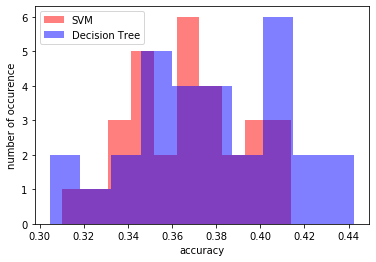

In [368]:
# svm
test_times = 30


ala = []
for i in range(test_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = svm.SVC(kernel='rbf',gamma='auto')
#     clf = make_pipeline(StandardScaler(),
#                     LinearSVC(random_state=42, tol=1e-5, max_iter=9000))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala.append(accuracy_score(y_test, y_pred))

# tree

ala2 = []
for i in range(test_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = tree.DecisionTreeClassifier()

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala2.append(accuracy_score(y_test, y_pred))
    
print(sum(ala)/test_times,sum(ala2)/test_times)

plt.xlabel('accuracy')
plt.ylabel('number of occurence')
plt.hist(ala, color='red', alpha=0.5, label='SVM')
plt.hist(ala2, color='blue', alpha=0.5, label='Decision Tree')
plt.legend()

100%|██████████| 10/10 [00:00<00:00, 45.54it/s]


beginnn
Classification score 0.41947322970639034 (pvalue : 0.09090909090909091)


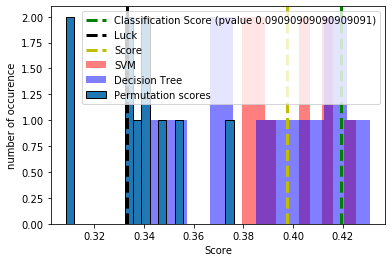

In [380]:
# permuattion scores
n_permutations = 10


# svm
test_times = 10


ala = []
for i in tqdm(range(test_times)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     clf = svm.SVC(kernel='rbf',gamma='auto')
    clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=9000, dual=False))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala.append(accuracy_score(y_test, y_pred))

ala2 = []
for i in tqdm(range(test_times)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = tree.DecisionTreeClassifier()

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala2.append(accuracy_score(y_test, y_pred))

plt.xlabel('accuracy')
plt.ylabel('number of occurence')
plt.hist(ala, color='red', alpha=0.5, label='SVM')
plt.hist(ala2, color='blue', alpha=0.5, label='Decision Tree')
plt.legend()



n_classes = np.unique(y).size

# Some noisy data not correlated
# random = np.random.RandomState(seed=0)
# E = random.normal(size=(len(X), 2200))

# # Add noisy data to the informative features for make the task harder
# X = np.c_[X, E]

clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=19000, dual=False))
# clf = tree.DecisionTreeClassifier()
cv = StratifiedKFold(3)

print('beginnn')

score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=-1,)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# plt.figure(figsize=(10,10))
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.plot(2 * [np.average(ala)], ylim, '--y', linewidth=3, label='Score')


plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [295]:
# permutation socre graph

source = pd.DataFrame({
    'type': ['Random', 'Permutation test', 'Graph feature SVM'],
    'score': [1. / n_classes, np.average(permutation_scores), score]
})
alt.Chart(source).mark_bar(size=50).encode(
    x=alt.X('type', axis=alt.Axis(labelAngle=0)),
    y='score',
    color = 'type'
).properties(
    width=300,
    height=200
    
)

alt.Chart(...)

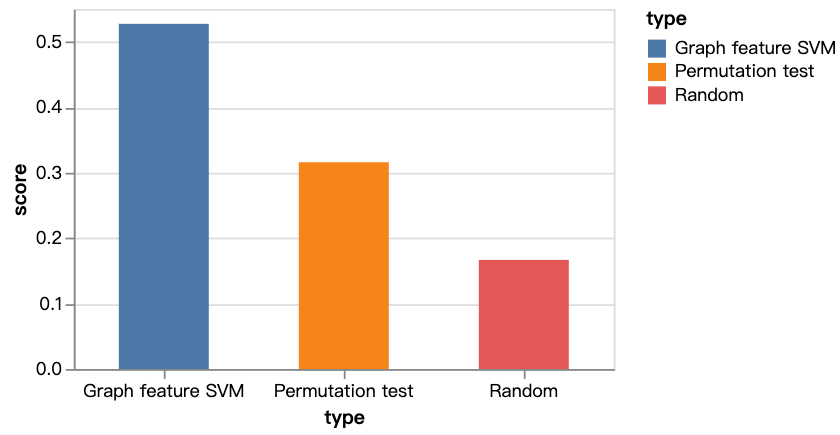

100%|██████████| 277/277 [00:00<00:00, 723.80it/s]


vectorizing start


  2%|▏         | 3/176 [00:00<00:07, 22.94it/s]

10.152363068999989
graph feature start


  0%|          | 0/5 [00:00<?, ?it/s]

28.341741910999986
SVM start


 40%|████      | 2/5 [00:00<00:00, 16.37it/s]

0.6045112781954888


100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


12.635903414999916
permutation start
438.80522301299993
Classification score 0.5993701328447091 (pvalue : 0.009900990099009901)


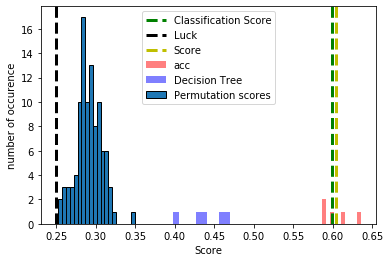

In [16]:
features = [
    'node',
    'edge',
    'clust',
    'apl',
    'sdev-apl', 
    'sdev-apl-g',
    'sdev-pagerank-g', 
    'sdev-pagerank', 
    'pagerank', 
    'pagerank-max', 
    'sdev-clust-g', 
    'sdev-clust', 
    'apl-g', 
]

names = [
#     'pop',
#     'jazz',
#     'the_beatles_1916',
#     'ramones_555', 
#     'frank_sinatra_11333', 
#     'metallica_954', 
#     'linkin_park_1025',
#     'passenger_21762',
#     'bruno_mars_28280',
    'adele_20519',
#     'elvis_presley_11125',
#     'blues',
#     'etta_james_20433',
#     'gary_moore_10959',
# #     'general',
# #     'metal',
# #     'rock',
    'billie_eilish_66748',
    'taylor_swift_16027',
    'lady_gaga_21818'
#     '1960',
#     '1970',
#     '1980',
]

permute_num = 5
vector_size=18
min_count=2
epochs=42
n_permutations = 100


nd = {i:num for num, i in enumerate(names)}
songs = []
song_categories = []
artists = [f'./{n}-2d/*.pickle' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):
        current = re.search(r'/([\w-]+).pickle',song_file)
        name = current.group(1)
        song = pickle.load(open(song_file, 'rb'))
        doc = TaggedDocument(song.get()[0],[nd[artist_name[:-3]]])
        songs.append(doc)
        song_categories.append(nd[artist_name[:-3]])
        
print('vectorizing start')
start = timer()

model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
model.build_vocab(songs)
model.train(songs, total_examples=model.corpus_count, epochs=model.epochs)

allvect = []
allres = []
for s in songs:
    vector = model.infer_vector(s.words)
    allvect.append(vector)
    allres.append(s.tags[0])
# print(vector)
end = timer()
print(end - start) 
print('graph feature start')
start = timer()
songs = []
# song_categories = []
counter = 0
artists = [f'./{n}-2d/*.edgelist' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):
        
        current = re.search(r'/([\w-]+).edgelist',song_file)
        name = current.group(1)
        
        G = nx.read_edgelist(song_file,comments='`',create_using=nx.MultiDiGraph)
        featurelist = list(weighted_apl_clust(G, features = features))
        songs.append(featurelist+list(allvect[counter]))
        counter+=1
#         song_categories.append(nd[artist_name[:-3]])


X,y = pd.DataFrame(songs), pd.Series(song_categories)

X = (X-X.mean())/X.std()

end = timer()
print(end - start) 
print('SVM start')
start = timer()
ala = []
for i in tqdm(range(permute_num)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # clf = svm.SVC(kernel='rbf',gamma='auto')
    clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=19000))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala.append(accuracy_score(y_test, y_pred))


print(np.average(ala))

ala2 = []
for i in tqdm(range(permute_num)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = tree.DecisionTreeClassifier()

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala2.append(accuracy_score(y_test, y_pred))



plt.xlabel('accuracy')
plt.ylabel('number of occurence')
plt.hist(ala, color='red', alpha=0.5, label='acc')
plt.hist(ala2, color='blue', alpha=0.5, label='Decision Tree')
plt.legend()
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282
print('permutation start')
start = timer()

n_classes = np.unique(y).size

# # Some noisy data not correlated
# random = np.random.RandomState(seed=0)
# E = random.normal(size=(len(X), 2200))

# # Add noisy data to the informative features for make the task harder
# X = np.c_[X, E]

# svm = SVC(kernel='linear')
clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=19000))
cv = StratifiedKFold(3)


score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=-1,)

end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282
print("Classification score %s (pvalue : %s)" % (score, pvalue))

# plt.figure(figsize=(10,10))
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score')

plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.plot(2 * [np.average(ala)], ylim, '--y', linewidth=3, label='Score')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

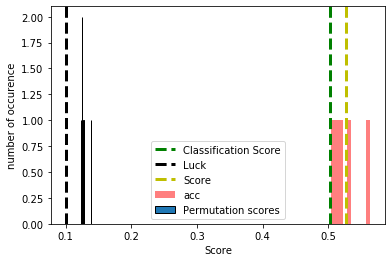

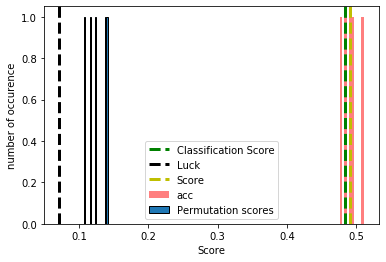

Genre

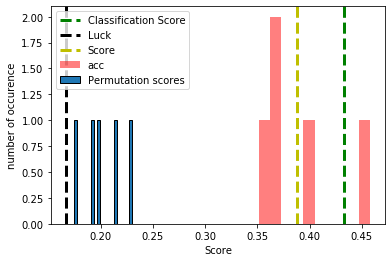

100%|██████████| 277/277 [00:00<00:00, 726.76it/s]


vectorizing start


  0%|          | 0/5 [00:00<?, ?it/s]

13.601090813000155
SVM start


100%|██████████| 5/5 [00:00<00:00, 33.84it/s]


0.37593984962406013
2.325047490000543
permutation start
6.831477312999596
Classification score 0.3950641319285387 (pvalue : 0.16666666666666666)


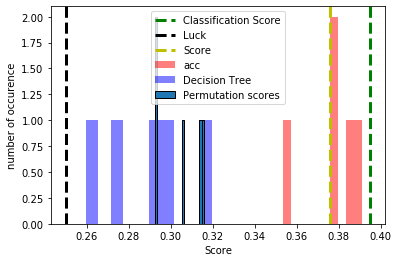

In [17]:
features = [
    'node',
    'edge',
    'clust',
    'apl',
    'sdev-apl', 
    'sdev-apl-g',
    'sdev-pagerank-g', 
    'sdev-pagerank', 
    'pagerank', 
    'pagerank-max', 
    'sdev-clust-g', 
    'sdev-clust', 
    'apl-g', 
]

names = [
#     'pop',
#     'jazz',
#     'the_beatles_1916',
#     'ramones_555', 
#     'frank_sinatra_11333', 
#     'metallica_954', 
#     'linkin_park_1025',
#     'passenger_21762',
#     'bruno_mars_28280',
    'adele_20519',
#     'elvis_presley_11125',
#     'blues',
#     'etta_james_20433',
#     'gary_moore_10959',
#     'general',
#     'metal',
#     'rock',
    'billie_eilish_66748',
    'taylor_swift_16027',
    'lady_gaga_21818',
#     '1960',
#     '1970',
#     '1980',
]

permute_num = 5
vector_size=2
min_count=0
epochs=50
n_permutations = 5


nd = {i:num for num, i in enumerate(names)}
songs = []
song_categories = []
artists = [f'./{n}-2d/*.pickle' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):
        current = re.search(r'/([\w-]+).pickle',song_file)
        name = current.group(1)
        song = pickle.load(open(song_file, 'rb'))
        doc = TaggedDocument(song.get()[0],[nd[artist_name[:-3]]])
        songs.append(doc)
        song_categories.append(nd[artist_name[:-3]])
        
print('vectorizing start')
start = timer()

model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
model.build_vocab(songs)
model.train(songs, total_examples=model.corpus_count, epochs=model.epochs)

allvect = []
allres = []
for s in songs:
    vector = model.infer_vector(s.words)
    allvect.append(vector)
    allres.append(s.tags[0])
# print(vector)
end = timer()
print(end - start) 

X,y = pd.DataFrame(allvect), pd.Series(song_categories)

print('SVM start')
start = timer()
ala = []
for i in tqdm(range(permute_num)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # clf = svm.SVC(kernel='rbf',gamma='auto')
    clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=9000))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala.append(accuracy_score(y_test, y_pred))



print(np.average(ala))

ala2 = []
for i in tqdm(range(permute_num)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf = tree.DecisionTreeClassifier()

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ala2.append(accuracy_score(y_test, y_pred))

plt.xlabel('accuracy')
plt.ylabel('number of occurence')
plt.hist(ala, color='red', alpha=0.5, label='acc')
plt.hist(ala2, color='blue', alpha=0.5, label='Decision Tree')
plt.legend()
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282
print('permutation start')
start = timer()

n_classes = np.unique(y).size


clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=9000))
cv = StratifiedKFold(3)


score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=-1,)

end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282
print("Classification score %s (pvalue : %s)" % (score, pvalue))

# plt.figure(figsize=(10,10))
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score')

plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.plot(2 * [np.average(ala)], ylim, '--y', linewidth=3, label='Score')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [335]:

names = [
#     'pop',
#     'jazz',
#     'the_beatles_1916',
#     'ramones_555', 
#     'frank_sinatra_11333', 
#     'metallica_954', 
#     'linkin_park_1025',
#     'bruno_mars_28280',
#     'adele_20519',
#     'elvis_presley_11125',
#     'blues',
#     'etta_james_20433',
#     'gary_moore_10959',
#     'general',
    'rock',
    'metal',
    'passenger_21762',
#     'billie_eilish_66748',
#     'taylor_swift_16027',
#     'lady_gaga_21818',
#     '1960',
#     '1970',
#     '1980',
]

permute_num = 5
vector_size=3
min_count=10
epochs=50
n_permutations = 5


nd = {i:num for num, i in enumerate(names)}
songs = []
song_categories = []
artists = [f'./{n}-2d/*.pickle' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):
        current = re.search(r'/([\w-]+).pickle',song_file)
        name = current.group(1)
        song = pickle.load(open(song_file, 'rb'))
        doc = TaggedDocument(song.get()[0],[artist_name])
        songs.append(doc)
        song_categories.append(artist_name)
        
print('vectorizing start')
start = timer()

model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
model.build_vocab(songs)
model.train(songs, total_examples=model.corpus_count, epochs=model.epochs)

allvect = []
allres = []
for s in songs:
    vector = model.infer_vector(s.words)
    allvect.append(vector)
    allres.append(s.tags[0])
# print(vector)
end = timer()
print(end - start) 

X,y = pd.DataFrame(allvect), pd.Series(song_categories)


100%|██████████| 192/192 [00:00<00:00, 1137.34it/s]


vectorizing start
8.268755904995487


In [338]:
X=X.rename(columns={0:'x',1:'y',2:'z'})
y = pd.DataFrame(y)
y=y.rename(columns={0:'artist'})
y['artist'] = y['artist'].apply(str)
source = X.join(y)

In [342]:
alt.Chart(source).mark_circle(size=60).encode(
    x='y',
    y='z',
    color=alt.Color('artist'),
    tooltip=['x', 'y', 'artist']
).interactive()

alt.Chart(...)

In [317]:
# permutation socre graph

source = pd.DataFrame({
    'type': ['Random', 'Permutation test', 'Graph feature SVM'],
    'score': [1. / n_classes, np.average(permutation_scores), score]
})
alt.Chart(source).mark_bar(size=50).encode(
    x=alt.X('type', axis=alt.Axis(labelAngle=0)),
    y='score',
    color = 'type'
).properties(
    width=300,
    height=200
    
)

alt.Chart(...)

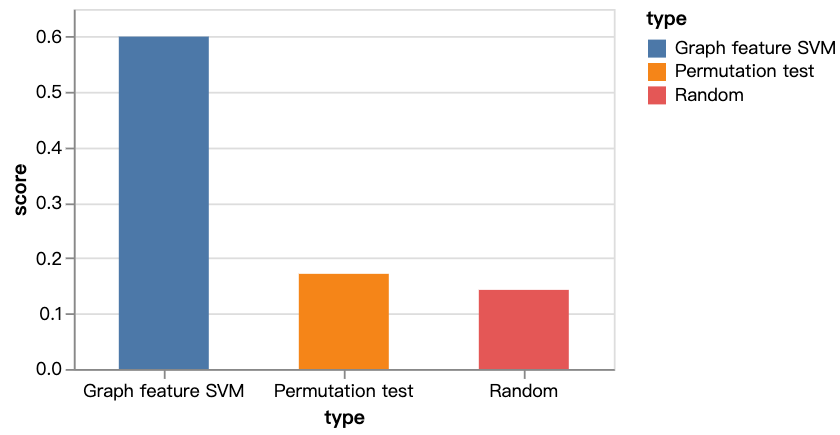

In [232]:
(nx.average_clustering(G),
nx.average_degree_connectivity(G),
nx.average_neighbor_degree(G),
nx.average_node_connectivity(G),
nx.average_shortest_path_length(G))

(0.39061041083099907,
 {8: 3.75, 5: 3.4, 6: 3.6666666666666665, 2: 4.375, 9: 1.1111111111111112},
 {'C': 3.0,
  'Am': 2.3333333333333335,
  'G': 3.6666666666666665,
  'C7': 3.0,
  'F': 1.6666666666666667,
  'Em': 3.0,
  'Eb': 3.0,
  'Fm': 5.0},
 1.3035714285714286,
 2.0357142857142856)

In [233]:

(nx.average_degree_connectivity(M),
nx.average_neighbor_degree(M),
nx.average_node_connectivity(M),
nx.average_shortest_path_length(M))

({28: 3.9285714285714284,
  22: 2.8181818181818183,
  26: 1.4615384615384615,
  32: 2.375,
  4: 6.5,
  2: 13.5},
 {'C': 3.9285714285714284,
  'Am': 2.8181818181818183,
  'F': 1.4615384615384615,
  'G': 2.375,
  'Em': 6.5,
  'C7': 13.0,
  'Eb': 6.5,
  'Fm': 14.0},
 1.3035714285714286,
 2.0357142857142856)

In [ ]:
r_data = []
for i in tqdm(ramones):
    M = nx.read_edgelist(i,comments='`',create_using=nx.MultiDiGraph)
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    r_data.append(apl_clust(G))
b_data = []
for i in tqdm(beatles):
    M = nx.read_edgelist(i,comments='`',create_using=nx.MultiDiGraph)
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    b_data.append(apl_clust(G))
xr,yr = [],[]
[(xr.append(i[0]),yr.append(i[1])) for i in r_data]
xb,yb = [],[]
[(xb.append(i[0]),yb.append(i[1])) for i in b_data]

plt.xlabel('clustering')
plt.ylabel('path length')

plt.scatter(xr,yr,c='blue')
plt.scatter(xb,yb,c='red')

0.16821702219474458

In [138]:
perartist = {}

artists = [f'./{n}-2d/*.pickle' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):
        current = re.search(r'/([\w-]+).pickle',song_file)
        name = current.group(1)
        song = pickle.load(open(song_file, 'rb'))
        artist_song_data+=song.get()[0]
    perartist[artist_name]=artist_song_data
pp.pprint([(i,len(j)) for i,j in perartist.items()])

100%|██████████| 3014/3014 [00:02<00:00, 1298.64it/s]

[   ('frank_sinatra_11333-2d', 11388),
    ('passenger_21762-2d', 18969),
    ('general-2d', 265285)]


Stored 'gg' (MultiDiGraph)


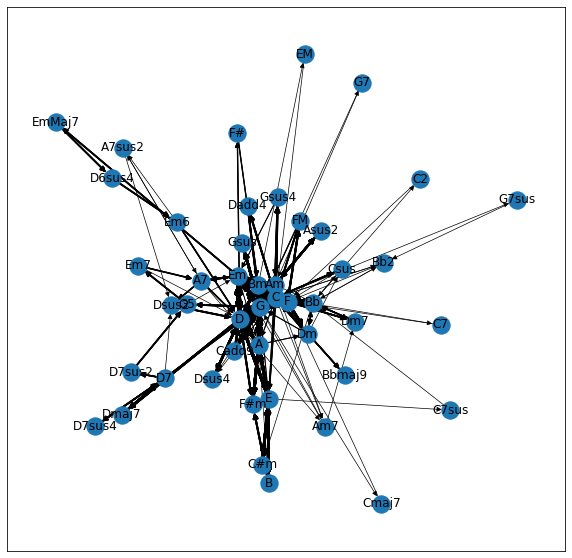

In [150]:
e = perartist['passenger_21762-2d']
gg = nx.MultiDiGraph()
gg.add_edges_from([[i,j] for i,j in zip(e[:3000-1],e[1:3000])])
%store gg
drawG(gg)

In [211]:
n = []
for i in [list(i[1].values())[1:] for i in nx.shortest_path_length(G)]:
    n+=i
n

[1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 3]

In [197]:
nx.average_shortest_path_length(G)

1.9285714285714286

In [226]:
np.std(list(nx.clustering(to_g(G)).values()))

0.3681171064778607

In [225]:
nx.average_clustering(to_g(G))

0.6142857142857142

In [237]:
nx.pagerank(to_g(G))

{'Bb7': 0.40880192489954836,
 'Ab7': 0.0388027331134868,
 'Eb9': 0.25749193816084337,
 'F9': 0.17693489224857328,
 'Ddim7': 0.0388703348433566,
 'Edim7': 0.039582889232030766,
 'E9': 0.039515287502160976}

In [252]:
for i in to_g(G).edges(data=True):
    print(i)

('Bb7', 'Ab7', {'weight': 2.0})
('Bb7', 'Bb7', {'weight': 8.0})
('Bb7', 'Eb9', {'weight': 18.0})
('Bb7', 'F9', {'weight': 10.0})
('Bb7', 'Ddim7', {'weight': 1.0})
('Bb7', 'E9', {'weight': 1.0})
('Eb9', 'Eb9', {'weight': 1.0})
('Eb9', 'Edim7', {'weight': 1.0})
('Eb9', 'F9', {'weight': 4.0})
('Eb9', 'Ddim7', {'weight': 1.0})
('F9', 'E9', {'weight': 1.0})
('F9', 'Edim7', {'weight': 1.0})


In [254]:
np.amax([1,2,3,4])

4

In [256]:
np.amax(list(nx.pagerank(to_g(G)).values()))

0.40880192489954836

In [257]:
np.std(list(nx.pagerank(to_g(G)).values()))

0.13523246828623858

In [593]:
names[0][0].lower().replace(' ','-')

'love-me-do'

In [652]:
for num, i in enumerate(df.iloc):
    i = list(i)[0]
    yass= False
    for jj in nn.keys():
        if jj in i: 
            yass = True
            print(jj,i,num)
            dfdict['year'][num] = nn[jj]
    if not yass:
        dfdict['year'][num] = 1955

        

all-you-need-is-love all-you-need-is-love-chords-655700 0
all-you-need-is-love all-you-need-is-love-chords-1044611 3
all-my-loving all-my-loving-ukulele-3003158 6
all-you-need-is-love all-you-need-is-love-chords-878481 7
all-together-now all-together-now-chords-683324 19
all-you-need-is-love all-you-need-is-love-ukulele-1789827 20
all-my-loving all-my-loving-chords-1089334 24
all-my-loving all-my-loving-chords-453882 27
a-taste-of-honey a-taste-of-honey-chords-1042348 28
ask-me-why ask-me-why-chords-273436 29
all-together-now all-together-now-chords-436646 30
ask-me-why ask-me-why-ukulele-3003209 33
girl another-girl-chords-644484 36
a-taste-of-honey a-taste-of-honey-chords-464384 37
and-your-bird-can-sing and-your-bird-can-sing-chords-1089326 39
all-my-loving all-my-loving-ukulele-2172741 41
all-you-need-is-love all-you-need-is-love-chords-1737297 42
girl another-girl-chords-891764 43
ask-me-why ask-me-why-ukulele-1362755 44
bad-boy bad-boy-chords-275239 48
all-together-now all-togeth

In [640]:
nn = {jj[0].lower().replace(' ','-'):jj[1] for jj in names}

In [618]:
list(nn.keys()).index('all-you-need-is-love')

83

In [634]:
dfdict = df.to_dict()
dfdict['year']={}

In [654]:
btdf = pd.DataFrame(dfdict)

In [163]:
names = [
#     'pop',
#     'jazz',
#     'the_beatles_1916',
#     'ramones_555', 
    'frank_sinatra_11333', 
#     'metallica_954', 
#     'linkin_park_1025',
    'passenger_21762',
#     'bruno_mars_28280',
#     'adele_20519',
#     'elvis_presley_11125',
# #     'john_denver_10167',
#     'blues',
#     'etta_james_20433',
#     'gary_moore_10959',
#     'general',
#     'metal',
#     'rock',
#     'billie_eilish_66748',/
#     'taylor_swift_16027',
#     'lady_gaga_21818'
]

nd = {i:num for num, i in enumerate(names)}


# features = ['node','apl', 'clust','sdev-apl','sdev-clust']
features = [
    'node',
    'edge',
    'clust',
    'sdev-clust',
    'apl',
    'sdev-apl',
    'clust-g',
    'pagerank-max',
    'sdev-pagerank',
    'pagerank',
]

songs = []
song_categories = []
artists = [f'./{n}-2d/*.pickle' for n in names]
for fl in artists:
    current = re.search(r'/([\w-]+)',fl)
    artist_name = current.group(1)
    artist = glob.glob(fl)
    artist_song_data = []
    for song_file in tqdm(artist):

        current = re.search(r'/([\w-]+).pickle',song_file)
        name = current.group(1)


        song = pickle.load(open(song_file, 'rb'))


        doc = TaggedDocument(s.get()[0],[nd[artist_name[:-3]]])
        songs.append(doc)
        song_categories.append(nd[artist_name[:-3]])
        # data.append([name, al]+list(weighted_apl_clust(G, features = features)))
#     songs+=data



# d = np.array(songs).T
# data = {
#     'name':d[0],
#     'artist':d[1],
# }
# for n, f in enumerate(features):
#     data[f]=d[n+2].astype(float)
# df = pd.DataFrame(data)
# df.head()

100%|██████████| 192/192 [00:00<00:00, 219.99it/s] 


In [164]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)
model.build_vocab(songs)
model.train(songs, total_examples=model.corpus_count, epochs=model.epochs)

In [131]:
# import os
# import gensim
# # Set file names for train and test data
# test_data_dir = os.path.join(gensim.__path__[0], 'test', 'test_data')
# lee_train_file = os.path.join(test_data_dir, 'lee_background.cor')
# lee_test_file = os.path.join(test_data_dir, 'lee.cor')

# import smart_open

# def read_corpus(fname, tokens_only=False):
#     with smart_open.open(fname, encoding="iso-8859-1") as f:
#         for i, line in enumerate(f):
#             tokens = gensim.utils.simple_preprocess(line)
#             if tokens_only:
#                 yield tokens
#             else:
#                 # For training data, add tags
#                 yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

# train_corpus = list(read_corpus(lee_train_file))
# test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

# train_corpus[10]

TaggedDocument(words=['work', 'is', 'continuing', 'this', 'morning', 'to', 'restore', 'power', 'supplies', 'to', 'tens', 'of', 'thousands', 'of', 'homes', 'that', 'were', 'blacked', 'out', 'during', 'wild', 'storms', 'that', 'struck', 'south', 'east', 'queensland', 'last', 'night', 'gale', 'force', 'winds', 'uprooted', 'trees', 'and', 'brought', 'down', 'power', 'lines', 'damaging', 'homes', 'and', 'cars', 'energex', 'and', 'ergon', 'energy', 'have', 'had', 'every', 'available', 'person', 'working', 'through', 'the', 'night', 'to', 'restore', 'power', 'at', 'locations', 'in', 'and', 'around', 'brisbane', 'west', 'to', 'toowoomba', 'and', 'north', 'to', 'the', 'sunshine', 'coast', 'at', 'boonah', 'south', 'west', 'of', 'brisbane', 'protective', 'tarpaulins', 'were', 'ripped', 'from', 'homes', 'still', 'undergoing', 'repairs', 'following', 'severe', 'storms', 'just', 'before', 'christmas', 'at', 'nambour', 'four', 'people', 'were', 'rescued', 'after', 'high', 'voltage', 'power', 'lines',

ModuleNotFoundError: No module named 'graphrole'

In [169]:
allvect = []
allres = []
for s in songs:
    vector = model.infer_vector(s.words)
    allvect.append(vector)
    allres.append(s.tags[0])
# print(vector)
pd.DataFrame(allvect)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.123017,0.002197,-0.151334,-0.087578,0.113280,0.008418,0.006873,-0.193056,-0.089784,0.133768,...,0.013649,-0.244552,-0.019555,-0.138348,0.022460,-0.083077,0.036120,0.073109,-0.143585,0.026693
1,-0.130288,-0.006173,-0.169626,-0.117400,0.120643,0.032636,-0.000598,-0.196883,-0.076371,0.139765,...,0.009429,-0.256254,-0.030111,-0.139480,0.005187,-0.071791,0.033317,0.064981,-0.128767,0.025151
2,-0.118778,0.018406,-0.133102,-0.057316,0.110734,-0.018296,0.001471,-0.177370,-0.098175,0.115427,...,0.023308,-0.229228,-0.008783,-0.133513,0.036647,-0.095973,0.035889,0.062529,-0.152686,0.021323
3,-0.117953,-0.004724,-0.151511,-0.091270,0.108044,0.018864,0.010861,-0.193948,-0.083026,0.138822,...,0.006674,-0.238435,-0.024902,-0.132806,0.014023,-0.069107,0.031228,0.080201,-0.134982,0.028378
4,-0.117086,-0.007673,-0.148608,-0.090674,0.105229,0.015563,0.018075,-0.198382,-0.089097,0.142399,...,0.006881,-0.241444,-0.020160,-0.137633,0.022574,-0.076872,0.037754,0.087892,-0.141550,0.032553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,-0.129136,0.025689,-0.150259,-0.055899,0.125389,-0.020023,-0.004106,-0.193636,-0.102507,0.125647,...,0.023660,-0.246683,-0.019462,-0.138476,0.026056,-0.090770,0.027277,0.065221,-0.162165,0.018583
334,-0.132489,0.000784,-0.162885,-0.100247,0.121799,0.010021,0.007455,-0.205150,-0.095913,0.141328,...,0.016362,-0.264211,-0.019112,-0.150258,0.026097,-0.094361,0.043380,0.074417,-0.152391,0.029120
335,-0.132445,0.017504,-0.155110,-0.074580,0.125579,-0.010669,-0.001359,-0.196645,-0.101517,0.129145,...,0.023587,-0.255888,-0.016669,-0.145430,0.029620,-0.098305,0.036637,0.064743,-0.160154,0.022189
336,-0.123913,-0.015769,-0.159978,-0.121033,0.109816,0.034160,0.011425,-0.195812,-0.079170,0.141591,...,0.007351,-0.251778,-0.021626,-0.142091,0.017064,-0.079391,0.043995,0.074629,-0.129279,0.031993


In [172]:
X,y = pd.DataFrame(allvect), pd.Series(allres)

In [73]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [75]:
import collections
counter = collections.Counter(ranks)
print(counter)

Counter({0: 292, 1: 8})


In [85]:
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (21): «the federal government says changes announced today to the work for the dole scheme will benefit participants and taxpayers federal employment services minister mal brough says that from july those taking part in work for the dole will be able to perform extra hours to complete their mutual obligation more quickly to access training credits»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (238, 0.7343647480010986): «centrelink is urging people affected by job cuts at regional pay tv operator austar and travel company traveland to seek information about their income support options traveland has announced it is shedding more than jobs around australia and austar is letting employees go centrelink finance information officer peter murray says those facing uncertain futures should head to centrelink in the next few days centrelink is the shopfront now for commonwealth services for income support and the employment network so that it is 

A | B | C
-|-|-
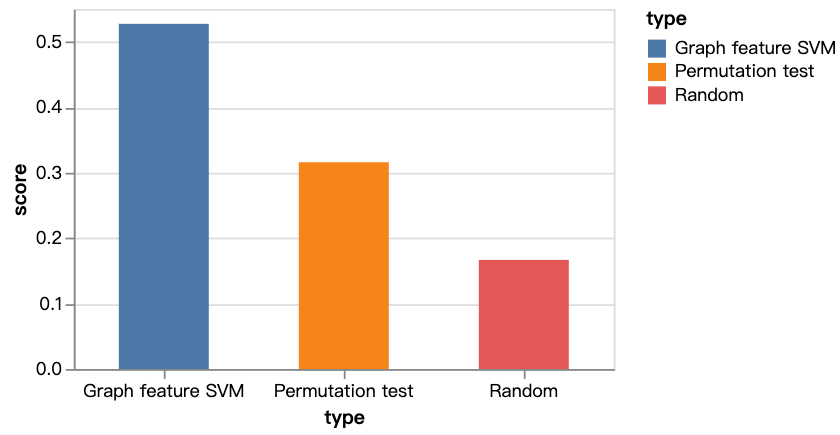 | 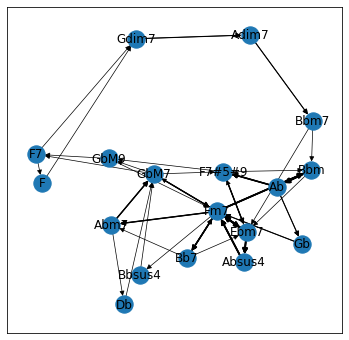 | 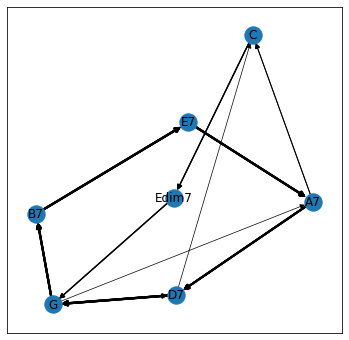

In [65]:
from gensim.models.doc2vec import TaggedDocument

In [68]:
TaggedDocument('ass ass rrff asdad'.split(), [0])

TaggedDocument(words=['ass', 'ass', 'rrff', 'asdad'], tags=[0])

In [81]:
'ass ass rrff asdad'.split()

['ass', 'ass', 'rrff', 'asdad']

In [84]:
TaggedDocument(s.get()[0],[al])
# print(TaggedDocument(['ass','popi'],[0]))

TaggedDocument(words=['C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C', 'G', 'Em', 'D', 'C'], tags=['pop-2d'])

In [140]:
pd.DataFrame(np.array(df).tolist(), columns=list(df))

,name,artist,node,edge,clust,sdev-clust,apl,sdev-apl,clust-g,pagerank-max,sdev-pagerank,pagerank
0,total-eclipse-of-the-heart-chords-960748,pop-2d,10.0,128.0,0.318846,0.257206,2.344444,1.055789,0.513333,0.214815,0.063995,0.100000
1,the-way-you-look-tonight-chords-742402,pop-2d,11.0,58.0,0.172727,0.135265,2.872727,1.434060,0.336364,0.158800,0.040432,0.090909
2,something-just-like-this-chords-1953009,pop-2d,6.0,217.0,0.503968,0.233048,1.933333,0.928559,0.761111,0.399684,0.137704,0.166667
3,sunrise-chords-529990,pop-2d,5.0,81.0,0.765812,0.045339,1.200000,0.400000,1.000000,0.248607,0.045636,0.200000
4,i-knew-you-were-trouble-chords-1187569,pop-2d,4.0,136.0,0.712500,0.087500,1.250000,0.433013,1.000000,0.340706,0.054571,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
2852,hair-ukulele-1352117,lady_gaga_21818-2d,5.0,137.0,0.250000,0.379144,1.600000,0.663325,0.333333,0.255467,0.082294,0.200000
2853,the-cure-chords-1982243,lady_gaga_21818-2d,5.0,123.0,0.727991,0.116596,1.350000,0.476970,0.900000,0.278780,0.060861,0.200000
2854,let-love-down-chords-927779,lady_gaga_21818-2d,6.0,106.0,0.683048,0.180778,1.700000,0.822598,0.805556,0.254378,0.088785,0.166667
2855,blueberry-kisses-ukulele-1379086,lady_gaga_21818-2d,4.0,27.0,0.812500,0.187500,1.333333,0.471405,0.833333,0.286575,0.038192,0.250000


In [138]:
df

,name,artist,node,edge,clust,sdev-clust,apl,sdev-apl,clust-g,pagerank-max,sdev-pagerank,pagerank
0,total-eclipse-of-the-heart-chords-960748,pop-2d,10.0,128.0,0.318846,0.257206,2.344444,1.055789,0.513333,0.214815,0.063995,0.100000
1,the-way-you-look-tonight-chords-742402,pop-2d,11.0,58.0,0.172727,0.135265,2.872727,1.434060,0.336364,0.158800,0.040432,0.090909
2,something-just-like-this-chords-1953009,pop-2d,6.0,217.0,0.503968,0.233048,1.933333,0.928559,0.761111,0.399684,0.137704,0.166667
3,sunrise-chords-529990,pop-2d,5.0,81.0,0.765812,0.045339,1.200000,0.400000,1.000000,0.248607,0.045636,0.200000
4,i-knew-you-were-trouble-chords-1187569,pop-2d,4.0,136.0,0.712500,0.087500,1.250000,0.433013,1.000000,0.340706,0.054571,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
2852,hair-ukulele-1352117,lady_gaga_21818-2d,5.0,137.0,0.250000,0.379144,1.600000,0.663325,0.333333,0.255467,0.082294,0.200000
2853,the-cure-chords-1982243,lady_gaga_21818-2d,5.0,123.0,0.727991,0.116596,1.350000,0.476970,0.900000,0.278780,0.060861,0.200000
2854,let-love-down-chords-927779,lady_gaga_21818-2d,6.0,106.0,0.683048,0.180778,1.700000,0.822598,0.805556,0.254378,0.088785,0.166667
2855,blueberry-kisses-ukulele-1379086,lady_gaga_21818-2d,4.0,27.0,0.812500,0.187500,1.333333,0.471405,0.833333,0.286575,0.038192,0.250000


In [323]:
X

,node,edge,clust,apl,sdev-apl,sdev-apl-g,sdev-pagerank-g,sdev-pagerank,pagerank,pagerank-max,sdev-clust-g,sdev-clust,apl-g
0,7.0,91.0,0.552381,1.976190,0.739630,0.499433,0.099961,0.103526,0.142857,0.324182,0.279699,0.299130,1.476190
1,8.0,53.0,0.239744,2.196429,0.933879,0.709807,0.102558,0.105719,0.125000,0.338805,0.321455,0.323887,1.821429
2,7.0,67.0,0.490842,1.928571,0.798596,0.587087,0.097415,0.098902,0.142857,0.284259,0.338397,0.344673,1.523810
3,14.0,145.0,0.580870,2.258242,0.794426,0.515196,0.064104,0.063993,0.071429,0.228005,0.350989,0.348535,1.769231
4,11.0,51.0,0.350996,1.909091,1.916839,1.809068,0.042081,0.046589,0.090909,0.201658,0.416598,0.381670,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,4.0,84.0,0.437500,1.500000,0.645497,0.471405,0.071988,0.072096,0.250000,0.364742,0.433013,0.369755,1.333333
1545,4.0,122.0,0.583333,1.416667,0.493007,0.000000,0.015427,0.018847,0.250000,0.281420,0.000000,0.083333,1.000000
1546,12.0,107.0,0.191863,3.810606,2.067543,1.183468,0.050292,0.060134,0.083333,0.217218,0.320048,0.293483,2.530303
1547,5.0,128.0,0.766667,1.400000,0.489898,0.458258,0.083322,0.085598,0.200000,0.308195,0.200000,0.243812,1.300000


In [324]:
X = (X-X.mean())/X.std()

,node,edge,clust,apl,sdev-apl,sdev-apl-g,sdev-pagerank-g,sdev-pagerank,pagerank,pagerank-max,sdev-clust-g,sdev-clust,apl-g
0,-0.103795,0.106810,0.483641,0.041531,-0.216466,-0.019648,0.963621,0.841369,-0.392997,0.346570,0.520572,1.079961,-0.033380
1,0.092516,-0.538148,-0.754263,0.355461,0.250240,0.723471,1.041246,0.900852,-0.610893,0.501108,0.827067,1.306242,0.774369
2,-0.103795,-0.300532,0.239976,-0.026346,-0.074794,0.289979,0.887551,0.715916,-0.392997,-0.075357,0.951422,1.496216,0.078033
3,1.270384,1.023329,0.596444,0.443571,-0.084811,0.036034,-0.108028,-0.231086,-1.264579,-0.669888,1.043846,1.531516,0.652242
4,0.681450,-0.572093,-0.313755,-0.054114,2.611914,4.606455,-0.766225,-0.703231,-1.026875,-0.948337,1.525422,1.834364,3.531857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,-0.692730,-0.011998,0.028763,-0.637238,-0.442630,-0.118653,0.127609,-0.011268,0.914376,0.775223,1.645909,1.725461,-0.367621
1545,-0.692730,0.632960,0.606198,-0.756022,-0.809006,-1.783824,-1.562856,-1.455822,0.914376,-0.105361,-1.532437,-0.892365,-1.147517
1546,0.877762,0.378371,-0.943851,2.656333,2.973999,2.396611,-0.520819,-0.335787,-1.119316,-0.783886,0.816738,1.028349,2.432913
1547,-0.496418,0.734795,1.332116,-0.779779,-0.816475,-0.165093,0.466352,0.354999,0.304268,0.177608,-0.064422,0.574375,-0.445611


In [488]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

# np.random.seed(1)


# def f(x):
#     """The function to predict."""
#     return x * np.sin(x)

# #----------------------------------------------------------------------
# #  First the noiseless case
# X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
# X = X.astype(np.float32)

# # Observations
# y = f(X).ravel()

# dy = 1.5 + 1.0 * np.random.random(y.shape)
# noise = np.random.normal(0, dy)
# y += noise
# y = y.astype(np.float32)

# # Mesh the input space for evaluations of the real function, the prediction and
# # its MSE
# xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
# xx = xx.astype(np.float32)

# alpha = 0.95

# clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
#                                 n_estimators=250, max_depth=3,
#                                 learning_rate=.1, min_samples_leaf=9,
#                                 min_samples_split=9)

# clf.fit(X, y)

# # Make the prediction on the meshed x-axis
# y_upper = clf.predict(xx)

# clf.set_params(alpha=1.0 - alpha)
# clf.fit(X, y)

# # Make the prediction on the meshed x-axis
# y_lower = clf.predict(xx)

# clf.set_params(loss='ls')
# clf.fit(X, y)

# # Make the prediction on the meshed x-axis
# y_pred = clf.predict(xx)

# # Plot the function, the prediction and the 95% confidence interval based on
# # the MSE
# fig = plt.figure()
# plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
# plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
# plt.plot(xx, y_pred, 'r-', label=u'Prediction')
# plt.plot(xx, y_upper, 'k-')
# plt.plot(xx, y_lower, 'k-')
# plt.fill(np.concatenate([xx, xx[::-1]]),
#          np.concatenate([y_upper, y_lower[::-1]]),
#          alpha=.5, fc='b', ec='None', label='95% prediction interval')
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
# plt.legend(loc='upper left')
# plt.show()

ImportError: cannot import name '_check_sample_weight' from 'sklearn.utils.validation' (/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py)